In [56]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
import numpy as np
import io
from pyspark.sql import SparkSession
from torchvision import datasets, transforms, models
from torchvision.utils import  make_grid

import os
from pyspark.sql.functions import isnan, when, count, col,create_map, lit
# from pyspark.sql.functions import col, create_map, lit
from itertools import chain

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
spark = SparkSession.builder.getOrCreate()

In [58]:
root_path = os.getcwd()
style_csv = root_path +  "/data/archive/styles.csv"
image_path = root_path + "/data/archive/less_images/"
df=spark.read.csv(style_csv,header=True)

In [59]:
df.show()

+-----+------+--------------+-----------+------------+----------+------+----+------+--------------------+
|   id|gender|masterCategory|subCategory| articleType|baseColour|season|year| usage|  productDisplayName|
+-----+------+--------------+-----------+------------+----------+------+----+------+--------------------+
|15970|   Men|       Apparel|    Topwear|      Shirts| Navy Blue|  Fall|2011|Casual|Turtle Check Men ...|
|39386|   Men|       Apparel| Bottomwear|       Jeans|      Blue|Summer|2012|Casual|Peter England Men...|
|59263| Women|   Accessories|    Watches|     Watches|    Silver|Winter|2016|Casual|Titan Women Silve...|
|21379|   Men|       Apparel| Bottomwear| Track Pants|     Black|  Fall|2011|Casual|Manchester United...|
|53759|   Men|       Apparel|    Topwear|     Tshirts|      Grey|Summer|2012|Casual|Puma Men Grey T-s...|
| 1855|   Men|       Apparel|    Topwear|     Tshirts|      Grey|Summer|2011|Casual|Inkfruit Mens Cha...|
|30805|   Men|       Apparel|    Topwear|     

In [60]:
# df.describe().show()  #for pyspark
df.describe().toPandas()

,summary,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,count,44446,44446,44446,44446,44446,44446,44425,44445,44445,44446
1,mean,29692.631350402735,None,None,None,None,None,None,2012.8059399257509,None,None
2,stddev,17048.234981940943,None,None,None,None,None,None,2.126401404408453,None,None
3,min,10000,Boys,Accessories,Accessories,Accessory Gift Set,Beige,Fall,2007,Casual,109F Blue A-Line Dress
4,max,9999,Women,Sporting Goods,Wristbands,Wristbands,Yellow,Winter,2019,Travel,united Colors Of Benetton Women Grey Tight


In [61]:
# df.summary().show()
df.summary().toPandas()

,summary,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,count,44446,44446,44446,44446,44446,44446,44425,44445,44445,44446
1,mean,29692.631350402735,None,None,None,None,None,None,2012.8059399257509,None,None
2,stddev,17048.234981940943,None,None,None,None,None,None,2.126401404408453,None,None
3,min,10000,Boys,Accessories,Accessories,Accessory Gift Set,Beige,Fall,2007,Casual,109F Blue A-Line Dress
4,25%,14771.0,None,None,None,None,None,None,2011.0,None,None
5,50%,28605.0,None,None,None,None,None,None,2012.0,None,None
6,75%,44676.0,None,None,None,None,None,None,2015.0,None,None
7,max,9999,Women,Sporting Goods,Wristbands,Wristbands,Yellow,Winter,2019,Travel,united Colors Of Benetton Women Grey Tight


In [62]:
# df.toPandas().info()

#pandas version is not correct for this statement to run sucesfully.

In [63]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+------+--------------+-----------+-----------+----------+------+----+-----+------------------+
| id|gender|masterCategory|subCategory|articleType|baseColour|season|year|usage|productDisplayName|
+---+------+--------------+-----------+-----------+----------+------+----+-----+------------------+
|  0|     0|             0|          0|          0|         0|     0|   0|    0|                 0|
+---+------+--------------+-----------+-----------+----------+------+----+-----+------------------+



In [64]:
df_pandas= df.toPandas()
[print(i, df_pandas[i].unique(), end="\n\n") for i in df_pandas.columns if df_pandas[i].dtype=='object']

id ['15970' '39386' '59263' ... '18842' '46694' '51623']

gender ['Men' 'Women' 'Boys' 'Girls' 'Unisex']

masterCategory ['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']

subCategory ['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Nails' 'Scarves' 'Dress'
 'Loungewear and Nightwear' 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers'
 'Skin Care' 'Makeup' 'Free Gifts' 'Ties' 'Accessories' 'Skin'
 'Beauty Accessories' 'Water Bottle' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']

articleType ['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lipstick' 'Flats'
 'K

[None, None, None, None, None, None, None, None, None, None]

In [65]:
# rf= df.select('masterCategory').distinct().rdd.map(lambda r: r[0]).collect()
[i.masterCategory for i in df.select("masterCategory").distinct().collect()]

['Sporting Goods',
 'Home',
 'Apparel',
 'Footwear',
 'Accessories',
 'Personal Care',
 'Free Items']

In [66]:
mapper = {}
for i,cat in enumerate([i.masterCategory for i in df.select("masterCategory").distinct().collect()]):
    mapper[cat] = i
print(mapper)

{'Sporting Goods': 0, 'Home': 1, 'Apparel': 2, 'Footwear': 3, 'Accessories': 4, 'Personal Care': 5, 'Free Items': 6}


In [67]:
# df =df.withColumn("targets",df.masterCategory.map(mapper))

In [68]:
#using udf, job is getting aborted
# def translate(mapping):
#     def translate_(col):
#         return mapping.get(col)
#     return udf(translate_, StringType())
# df.withColumn("value", translate(mapper)("masterCategory")).show()

In [69]:
from pyspark.sql.functions import col, create_map, lit
from itertools import chain

mapping_expr = create_map([lit(x) for x in chain(*mapper.items())])

df = df.withColumn("targets", mapping_expr.getItem(col("masterCategory"))).show()

+-----+------+--------------+-----------+------------+----------+------+----+------+--------------------+-------+
|   id|gender|masterCategory|subCategory| articleType|baseColour|season|year| usage|  productDisplayName|targets|
+-----+------+--------------+-----------+------------+----------+------+----+------+--------------------+-------+
|15970|   Men|       Apparel|    Topwear|      Shirts| Navy Blue|  Fall|2011|Casual|Turtle Check Men ...|      2|
|39386|   Men|       Apparel| Bottomwear|       Jeans|      Blue|Summer|2012|Casual|Peter England Men...|      2|
|59263| Women|   Accessories|    Watches|     Watches|    Silver|Winter|2016|Casual|Titan Women Silve...|      4|
|21379|   Men|       Apparel| Bottomwear| Track Pants|     Black|  Fall|2011|Casual|Manchester United...|      2|
|53759|   Men|       Apparel|    Topwear|     Tshirts|      Grey|Summer|2012|Casual|Puma Men Grey T-s...|      2|
| 1855|   Men|       Apparel|    Topwear|     Tshirts|      Grey|Summer|2011|Casual|Inkf

In [70]:
#EMBEDDINGS

In [71]:
path = "../case_study/data/archive/less_images"
img_names= []

for folder, subfolders,filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder + "/" + img)

In [72]:
len(img_names)

11

In [73]:
img_sizes=[]
rejected=[]

for item in img_names:
    try:
        with Image.open(item) as img:
            imag_sizes.append(img.size)
    except:
        rejected.append(img.size)

In [74]:
print(len(img_sizes))
print(len(rejected))

0
11


In [75]:
df=pd.DataFrame(rejected)

In [76]:
df.head()

,0,1
0,60,80
1,60,80
2,60,80
3,60,80
4,60,80


In [77]:
df[0].unique()

array([60], dtype=int64)

In [78]:
df[1].unique()

array([80], dtype=int64)

In [79]:
df[0].describe()

count    11.0
mean     60.0
std       0.0
min      60.0
25%      60.0
50%      60.0
75%      60.0
max      60.0
Name: 0, dtype: float64

In [80]:
df[1].describe()

count    11.0
mean     80.0
std       0.0
min      80.0
25%      80.0
50%      80.0
75%      80.0
max      80.0
Name: 1, dtype: float64

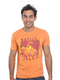

In [81]:
from IPython import display
display.Image(r"../case_study/data/archive/less_images/2057.jpg")

In [82]:
shirt=Image.open("../case_study/data/archive/less_images/2057.jpg")

In [83]:
print(shirt.size)
print(shirt.getpixel((0,0)))

(60, 80)
(255, 255, 255)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


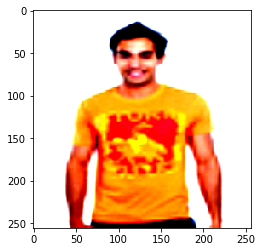

In [84]:
tc = transforms.Compose([
        transforms.Resize((256, 256)),
#         transforms.RandomHorizontalFlip(p=0.2),
#         transforms.RandomRotation(30),
#         transforms.CenterCrop(30),
        transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ])
im= tc(shirt)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [85]:
im

tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.

In [86]:
# root_path = os.getcwd()
# # style_csv = root_path +  "/data/archive/styles.csv"
# image_path = root_path + "/data/archive/less_images/*jpg"
data_dir = 'data/archive/'
image_datasets = datasets.ImageFolder(data_dir, transform=tc)
dloader = torch.utils.data.DataLoader(image_datasets, batch_size=10, shuffle=False)

In [87]:
print(len(image_datasets))
print((image_datasets.classes))

11
['less_images']


In [88]:
image_datasets

Dataset ImageFolder
    Number of datapoints: 11
    Root location: data/archive/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

torch.Size([256, 256, 3])
tensor([[[1.2214, 1.2214, 1.2214,  ..., 1.2385, 1.2385, 1.2385],
         [1.2214, 1.2214, 1.2214,  ..., 1.2385, 1.2385, 1.2385],
         [1.2214, 1.2214, 1.2214,  ..., 1.2385, 1.2385, 1.2385],
         ...,
         [1.2043, 1.2043, 1.2043,  ..., 1.1700, 1.1700, 1.1700],
         [1.2043, 1.2043, 1.2043,  ..., 1.1700, 1.1700, 1.1700],
         [1.2043, 1.2043, 1.2043,  ..., 1.1700, 1.1700, 1.1700]],

        [[1.3256, 1.3256, 1.3256,  ..., 1.3431, 1.3431, 1.3431],
         [1.3256, 1.3256, 1.3256,  ..., 1.3431, 1.3431, 1.3431],
         [1.3256, 1.3256, 1.3256,  ..., 1.3431, 1.3431, 1.3431],
         ...,
         [1.3081, 1.3081, 1.3081,  ..., 1.2731, 1.2731, 1.2731],
         [1.3081, 1.3081, 1.3081,  ..., 1.2731, 1.2731, 1.2731],
         [1.3081, 1.3081, 1.3081,  ..., 1.2731, 1.2731, 1.2731]],

        [[1.4200, 1.4200, 1.4200,  ..., 1.4722, 1.4722, 1.4722],
         [1.4200, 1.4200, 1.4200,  ..., 1.4722, 1.4722, 1.4722],
         [1.4200, 1.4200, 1.4200

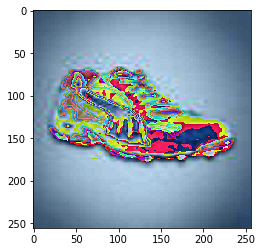

In [89]:
for img, label in dloader:
    print(np.transpose(img[0], (1,2,0)).shape)
    print(img[0])
    plt.imshow((img[0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
    plt.show()
    break

In [90]:
len(image_datasets)

11

In [91]:
def copy_embeddings(m, i, o):
    """Copy embeddings from the penultimate layer.
    """
    o = o[:, :, 0, 0].detach().numpy().tolist()
    outputs.append(o)

In [92]:
# fetch pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in C:\Users\Ashish Verma-GGN/.cache\torch\hub\pytorch_vision_v0.10.0


In [93]:
# Select the desired layer
layer = model._modules.get('avgpool')
# attach hook to the penulimate layer
_ = layer.register_forward_hook(copy_embeddings)

In [94]:
outputs = []  # list of embeddings

model.eval() # Inference mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [95]:
# Generate image's embeddings for all images in dloader and saves 
# them in the list outputs
for X, y in dloader:
    _ = model(X)
    print(_)

tensor([[ 0.4690, -0.6061, -4.4715,  ..., -2.7464,  0.7810,  0.6346],
        [ 0.9809, -1.9817, -4.0056,  ..., -2.2696,  0.4793,  0.9694],
        [-0.3154, -1.1334, -2.7672,  ..., -2.3327, -0.5399,  2.2669],
        ...,
        [ 2.8202, -2.1394,  0.2698,  ..., -3.0552, -0.5379,  0.6062],
        [ 2.1923, -1.9860, -1.7486,  ..., -2.2355,  0.5034,  0.5336],
        [ 2.4138, -1.4972, -0.0658,  ..., -1.9472,  0.8682,  1.0241]],
       grad_fn=<AddmmBackward0>)
tensor([[ 2.4717e+00, -1.8431e+00, -5.7360e-01, -1.9365e+00, -2.0677e-01,
         -1.2043e+00, -2.2326e+00, -3.2379e+00, -4.7691e+00, -9.0228e-01,
         -1.2439e+00, -3.0420e+00, -3.8597e+00, -3.6073e+00, -3.5253e+00,
         -2.0469e+00, -3.0325e+00, -3.2049e+00, -3.5834e+00, -1.7455e+00,
         -2.6297e+00, -8.4262e-01, -2.1725e+00, -3.2823e+00, -3.2652e+00,
         -2.4350e+00, -2.1026e+00, -1.8969e+00, -1.0589e+00, -3.3775e+00,
         -2.9633e+00, -2.2576e+00, -1.2397e+00,  1.0128e+00,  2.1729e+00,
         -1.042

       grad_fn=<AddmmBackward0>)
